In [ ]:

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3


In [ ]:
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
from keras.models import load_model
import os


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/RGB_5G.zip" -d "/content/dataset/"  

Archive:  /content/drive/MyDrive/RGB_5G.zip
   creating: /content/dataset/RGB_5G/Test/
   creating: /content/dataset/RGB_5G/Test/16QAM/
  inflating: /content/dataset/RGB_5G/Test/16QAM/4QAM_RGB1.png  
  inflating: /content/dataset/RGB_5G/Test/16QAM/4QAM_RGB10.png  
  inflating: /content/dataset/RGB_5G/Test/16QAM/4QAM_RGB100.png  
  inflating: /content/dataset/RGB_5G/Test/16QAM/4QAM_RGB101.png  
  inflating: /content/dataset/RGB_5G/Test/16QAM/4QAM_RGB102.png  
  inflating: /content/dataset/RGB_5G/Test/16QAM/4QAM_RGB103.png  
  inflating: /content/dataset/RGB_5G/Test/16QAM/4QAM_RGB104.png  
  inflating: /content/dataset/RGB_5G/Test/16QAM/4QAM_RGB105.png  
  inflating: /content/dataset/RGB_5G/Test/16QAM/4QAM_RGB106.png  
  inflating: /content/dataset/RGB_5G/Test/16QAM/4QAM_RGB107.png  
  inflating: /content/dataset/RGB_5G/Test/16QAM/4QAM_RGB108.png  
  inflating: /content/dataset/RGB_5G/Test/16QAM/4QAM_RGB109.png  
  inflating: /content/dataset/RGB_5G/Test/16QAM/4QAM_RGB11.png  
  inflatin

In [ ]:
IMAGE_SIZE = [224, 224]
valid_path = r'/content/dataset/RGB_5G/Test'
train_path = r'/content/dataset/RGB_5G/Train'

# Models

We can first distribute the model into CNN layers then pass it into the InveptionV3 model for further neural network complexity.

In [ ]:
!nvidia-smi

Tue Nov 15 03:38:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

<h2>Inception-V3 model structure</h2>
This is the structure of the Inception-V3 model, developed over the imagenet dataset.


<img src="https://i.imgur.com/kdXUzu1.png" width="1000px"/>
source: https://hackathonprojects.files.wordpress.com/2016/09/74911-image03.png

The top layers (including classification) are not included. These layers will be replaced for the following layers:

In [ ]:
#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

<h2>New Top layers</h2>
Layers to be trained with the new model.
<img src="https://i.imgur.com/rWF7bRY.png" width="800px"/>

In [ ]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 5s 0us/step


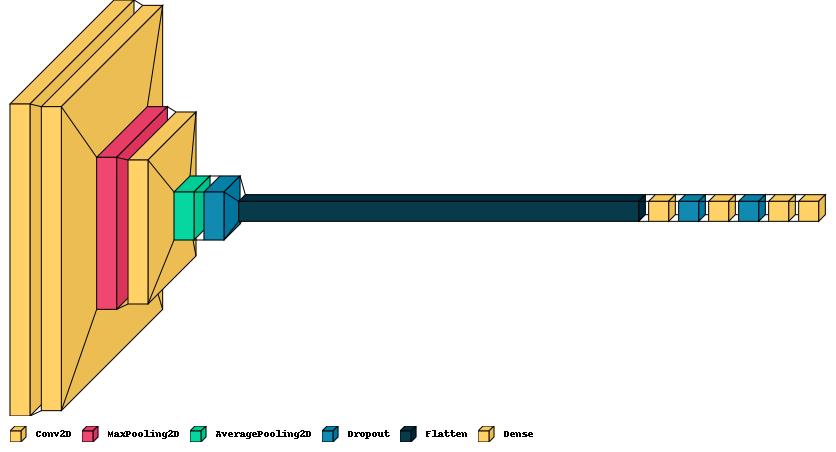

In [ ]:
#visualkeras.layered_view(cnn_model,legend=True).show() # display using your system viewer
visualkeras.layered_view(cnn_model, to_file=path2+'/output2.png') # write to disk
#visualkeras.layered_view(cnn_model, to_file=path2+'/output.png').show() # write and show

visualkeras.layered_view(cnn_model,legend=True)

In [ ]:
for layer in inception.layers:
    layer.trainable = False

In [ ]:
folders = glob(r'/content/dataset/RGB_5G/Train/*')

In [ ]:
x = Flatten()(inception.output)
prediction = Dense(len(folders), activation='softmax')(x)

In [ ]:
model_5G_final = Model(inputs=inception.input, outputs=prediction)
prediction = Dense(len(folders), activation='softmax')(x)

In [ ]:
model_5G_final.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
model_5G_final.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
import tensorflow as tf
from keras import backend as K
from keras.applications.inception_v3 import preprocess_input
import numpy as np
IMG_SIZE = (512, 512) # slightly smaller than vgg16 normally expects
def tf_image_loader(out_size, 
                      horizontal_flip = True, 
                      vertical_flip = False, 
                     random_brightness = True,
                     random_contrast = True,
                    random_saturation = True,
                    random_hue = True,
                      color_mode = 'rgb',
                       preproc_func = preprocess_input,
                       on_batch = False):
    def _func(X):
        with tf.name_scope('image_augmentation'):
            with tf.name_scope('input'):
                X = tf.image.decode_png(tf.read_file(X), channels = 3 if color_mode == 'rgb' else 0)
                X = tf.image.resize_images(X, out_size)
            with tf.name_scope('augmentation'):
                if horizontal_flip:
                    X = tf.image.random_flip_left_right(X)
                if vertical_flip:
                    X = tf.image.random_flip_up_down(X)
                if random_brightness:
                    X = tf.image.random_brightness(X, max_delta = 0.1)
                if random_saturation:
                    X = tf.image.random_saturation(X, lower = 0.75, upper = 1.5)
                if random_hue:
                    X = tf.image.random_hue(X, max_delta = 0.15)
                if random_contrast:
                    X = tf.image.random_contrast(X, lower = 0.75, upper = 1.5)
                return preproc_func(X)
    if on_batch: 
        # we are meant to use it on a batch
        def _batch_func(X, y):
            return tf.map_fn(_func, X), y
        return _batch_func
    else:
        # we apply it to everything
        def _all_func(X, y):
            return _func(X), y         
        return _all_func
    
def tf_augmentor(out_size,
                intermediate_size = (640, 640),
                 intermediate_trans = 'crop',
                 batch_size = 16,
                   horizontal_flip = True, 
                  vertical_flip = False, 
                 random_brightness = True,
                 random_contrast = True,
                 random_saturation = True,
                    random_hue = True,
                  color_mode = 'rgb',
                   preproc_func = preprocess_input,
                   min_crop_percent = 0.001,
                   max_crop_percent = 0.005,
                   crop_probability = 0.5,
                   rotation_range = 10):
    
    load_ops = tf_image_loader(out_size = intermediate_size, 
                               horizontal_flip=horizontal_flip, 
                               vertical_flip=vertical_flip, 
                               random_brightness = random_brightness,
                               random_contrast = random_contrast,
                               random_saturation = random_saturation,
                               random_hue = random_hue,
                               color_mode = color_mode,
                               preproc_func = preproc_func,
                               on_batch=False)
    def batch_ops(X, y):
        batch_size = tf.shape(X)[0]
        with tf.name_scope('transformation'):
            # code borrowed from https://becominghuman.ai/data-augmentation-on-gpu-in-tensorflow-13d14ecf2b19
            # The list of affine transformations that our image will go under.
            # Every element is Nx8 tensor, where N is a batch size.
            transforms = []
            identity = tf.constant([1, 0, 0, 0, 1, 0, 0, 0], dtype=tf.float32)
            if rotation_range > 0:
                angle_rad = rotation_range / 180 * np.pi
                angles = tf.random_uniform([batch_size], -angle_rad, angle_rad)
                transforms += [tf.contrib.image.angles_to_projective_transforms(angles, intermediate_size[0], intermediate_size[1])]

            if crop_probability > 0:
                crop_pct = tf.random_uniform([batch_size], min_crop_percent, max_crop_percent)
                left = tf.random_uniform([batch_size], 0, intermediate_size[0] * (1.0 - crop_pct))
                top = tf.random_uniform([batch_size], 0, intermediate_size[1] * (1.0 - crop_pct))
                crop_transform = tf.stack([
                      crop_pct,
                      tf.zeros([batch_size]), top,
                      tf.zeros([batch_size]), crop_pct, left,
                      tf.zeros([batch_size]),
                      tf.zeros([batch_size])
                  ], 1)
                coin = tf.less(tf.random_uniform([batch_size], 0, 1.0), crop_probability)
                transforms += [tf.where(coin, crop_transform, tf.tile(tf.expand_dims(identity, 0), [batch_size, 1]))]
            if len(transforms)>0:
                X = tf.contrib.image.transform(X,
                      tf.contrib.image.compose_transforms(*transforms),
                      interpolation='BILINEAR') # or 'NEAREST'
            if intermediate_trans=='scale':
                X = tf.image.resize_images(X, out_size)
            elif intermediate_trans=='crop':
                X = tf.image.resize_image_with_crop_or_pad(X, out_size[0], out_size[1])
            else:
                raise ValueError('Invalid Operation {}'.format(intermediate_trans))
            return X, y
    def _create_pipeline(in_ds):
        batch_ds = in_ds.map(load_ops, num_parallel_calls=4).batch(batch_size)
        return batch_ds.map(batch_ops)
    return _create_pipeline

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 1400 images belonging to 5 classes.
Found 600 images belonging to 5 classes.


In [ ]:
history_IV3_final = model_5G_final.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)    

model_5G_final.save('InceptionV3_5G_model.h5')

Epoch 1/10
44/44 [==============================] - 44s 703ms/step - loss: 8.1293 - accuracy: 0.2236 - val_loss: 4.7700 - val_accuracy: 0.2117
Epoch 2/10
44/44 [==============================] - 29s 661ms/step - loss: 4.0385 - accuracy: 0.3286 - val_loss: 4.8739 - val_accuracy: 0.2250
Epoch 3/10
44/44 [==============================] - 31s 705ms/step - loss: 2.8760 - accuracy: 0.3407 - val_loss: 3.0019 - val_accuracy: 0.3033
Epoch 4/10
44/44 [==============================] - 30s 689ms/step - loss: 2.5511 - accuracy: 0.4079 - val_loss: 2.8365 - val_accuracy: 0.3200
Epoch 5/10
44/44 [==============================] - 29s 663ms/step - loss: 2.4009 - accuracy: 0.4343 - val_loss: 3.1868 - val_accuracy: 0.3350
Epoch 6/10
44/44 [==============================] - 29s 659ms/step - loss: 2.3327 - accuracy: 0.4650 - val_loss: 3.3047 - val_accuracy: 0.3083
Epoch 7/10
44/44 [==============================] - 29s 654ms/step - loss: 2.3772 - accuracy: 0.4771 - val_loss: 6.6796 - val_accuracy: 0.2617

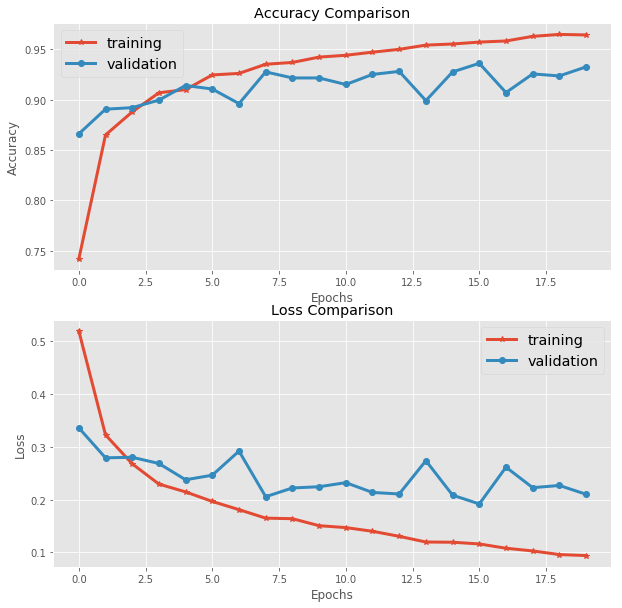

In [ ]:
def visualize_training(history, lw = 3):
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot(history.history['acc'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_acc'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(fontsize = 'x-large')

    plt.subplot(2,1,2)
    plt.plot(history.history['loss'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_loss'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize = 'x-large')
    plt.grid(True)
    plt.show()


visualize_training(hist)

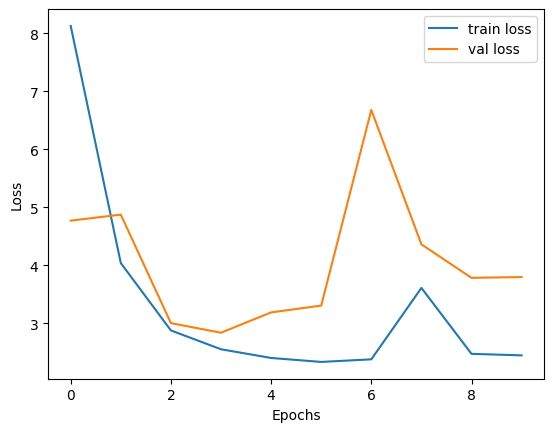

In [ ]:
plt.plot(history_IV3_final.history['loss'], label='train loss')
plt.plot(history_IV3_final.history['val_loss'], label='val loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

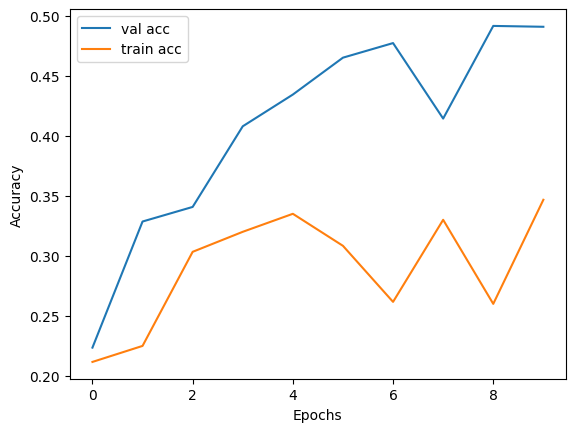

In [ ]:
plt.plot(history_IV3_final.history['accuracy'], label='val acc')
plt.plot(history_IV3_final.history['val_accuracy'], label='train acc')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
model_IV3_5G_final = load_model('InceptionV3_5G_model.h5')


In [ ]:
model_IV3_5G_final.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
test_generator = ImageDataGenerator(rescale = 1./255)
test_data_generator = test_generator.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

Found 600 images belonging to 5 classes.


In [ ]:
predictions = model_IV3_5G_final.predict(test_data_generator, steps=test_steps_per_epoch)

19/19 [==============================] - 6s 276ms/step


In [ ]:
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)

[0 0 0 0 4 3 4 2 3 2 2 0 2 4 0 4 0 2 2 2 0 4 4 2 0 4 0 2 0 0 0 0 2 2 0 2 0
 4 2 0 2 0 2 4 0 2 0 2 2 0 0 0 2 0 0 2 3 0 0 0 2 0 2 1 2 3 0 0 0 0 0 0 2 2
 2 2 0 2 4 0 0 4 0 4 2 0 2 2 0 0 0 0 2 0 0 2 2 2 0 4 2 2 0 0 2 3 0 2 4 0 0
 2 2 2 0 4 2 0 0 0 4 4 4 4 4 4 4 3 4 4 4 0 3 3 0 4 4 2 4 4 0 4 4 4 0 0 0 4
 3 0 4 0 4 4 4 4 3 3 4 4 4 4 4 4 4 0 0 4 3 4 4 4 4 4 1 3 4 4 3 4 4 0 4 0 3
 3 3 4 3 4 4 4 4 4 3 1 4 4 4 4 3 4 4 4 0 4 3 3 2 4 4 3 4 2 4 1 3 4 4 4 4 0
 4 3 3 3 3 4 0 4 3 4 4 4 0 4 4 4 3 3 2 2 0 2 2 4 0 4 0 2 2 0 0 0 4 3 2 2 2
 2 2 0 4 0 4 0 0 2 2 0 0 0 0 0 0 4 0 0 0 2 2 0 0 2 0 4 2 0 0 2 4 2 2 4 0 2
 4 0 2 2 2 0 0 0 0 2 0 0 0 2 4 2 0 0 2 0 2 2 0 0 0 0 2 0 0 2 2 4 0 0 0 0 2
 0 2 2 0 0 0 2 1 0 3 0 2 2 0 0 2 2 0 4 2 3 0 0 2 2 0 0 4 0 3 4 3 4 4 0 4 4
 4 0 4 4 3 3 1 2 3 4 3 3 4 3 4 4 0 3 1 4 3 3 3 2 4 4 4 2 4 4 4 1 3 3 3 4 4
 3 4 4 0 3 4 4 3 4 4 4 4 4 4 4 4 3 3 4 3 3 3 3 3 4 4 4 4 3 4 4 4 3 4 4 4 3
 0 3 3 3 0 4 3 2 3 4 4 4 4 4 1 4 4 4 4 3 4 0 4 3 0 4 3 3 4 3 4 4 0 4 3 3 3
 4 4 4 4 4 4 0 4 0 3 4 4 

In [ ]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())

In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
cmat = confusion_matrix(true_classes, predicted_classes)
acc = accuracy_score(true_classes, predicted_classes)
print(report) 
print(cmat)
print(acc)

              precision    recall  f1-score   support

       16QAM       0.36      0.47      0.41       120
       32QAM       0.17      0.03      0.04       120
        4QAM       0.45      0.37      0.41       120
       64QAM       0.39      0.33      0.36       120
        8QAM       0.29      0.54      0.37       120

    accuracy                           0.35       600
   macro avg       0.33      0.35      0.32       600
weighted avg       0.33      0.35      0.32       600

[[56  1 43  5 15]
 [16  3  3 26 72]
 [59  1 44  3 13]
 [10  4  4 40 62]
 [14  9  3 29 65]]
0.3466666666666667


In [ ]:
from keras.applications.vgg16 import VGG16 as PTModel
from keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel
from keras.applications.inception_v3 import InceptionV3 as PTModel
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(t_x.shape[1:])
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, 
                    kernel_size = (1,1), 
                    padding = 'valid', 
                    activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(t_y.shape[-1], activation = 'softmax')(dr_steps)
retina_model = Model(inputs = [in_lay], outputs = [out_layer])
from keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

retina_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
retina_model.summary()

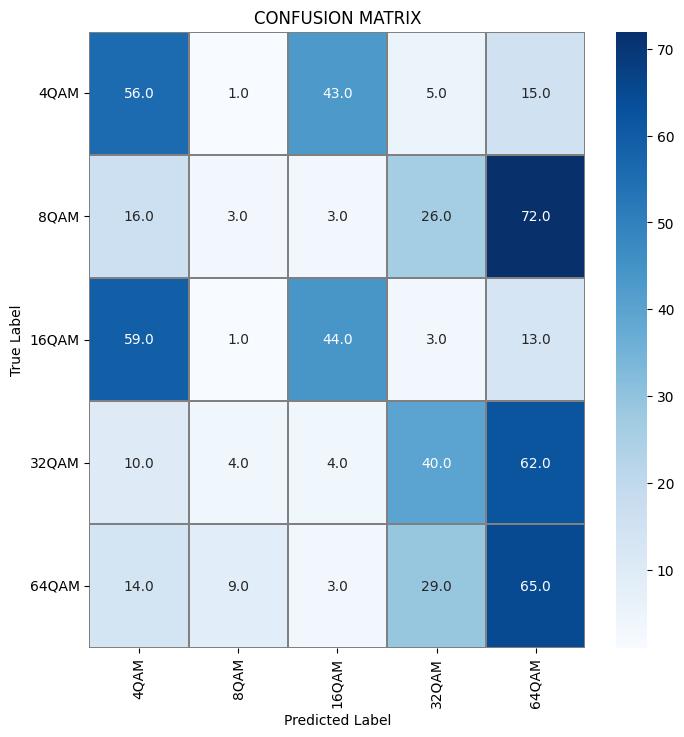

In [ ]:
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Blues", linecolor="gray", fmt='.1f', ax=ax)

# Set labels and ticks
labels = ['4QAM', '8QAM', '16QAM', '32QAM', '64QAM']
ax.set_xticklabels(labels, rotation=90)
ax.set_yticklabels(labels, rotation=0)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.title("CONFUSION MATRIX")
plt.show()

### 5. Conclusion

The built model using transfer learning from the InceptionV3 and adding custom layers successfully recognize the signal giving certain picture with <b>94.8% of accuracy over the test data</b>. Nevertheless, there are some limitations detected and opportunities for improvements:

* Train the algorithms with the entire data. Due computational resource limitation, the model was train with a subset of images. Having an appropriate machine, the model can be trained including all the images. This will make the algorithm to learn from different context of the picture giving it more experience in order to predict better never seen images.

* Use difference structures for the CNNs. This approach could give better performance to the model, is an expensive task anyway, as the model can be measure on the test data set after is trained, and this takes time and computational resources.

* Environments where there are more than one subject in the picture was not part of the scope of this Notebook, but it is a good improvement in order to develop a better application.


